# Portfolio
Brian Howard
27 July 2020

In [1]:
library(UsingR)
library(quantmod)
library(ggplot2)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tools)
library(zoo)
library(signal)
library(stringr)
library(corrplot)
library(Hmisc)
library(tseries)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Quandl)
library(nnet)
#library(devtools)
#install_github("andrewuhl/RollingWindow")
library(RollingWindow)
library(gtable)
library(data.table)
library(readxl)
library(IRdisplay)

Loading required package: MASS

Loading required package: HistData

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'UsingR'


The following object is masked from 'package:survival':

    cancer


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new data defaults. See ?getSymbols.


Attaching package: 'quantmod'


The following object is masked from 'package:Hmisc':

    Lag



Attaching package: 'signal'


The following objects are masked from 'package:stats'

Define the source of the data (local or web) and whether to update the models.

Call helper functions

In [28]:
source("plotHelper.r")

These functions help organize tables in the document

In [30]:
tblPort <- function(rrData, datay){
  
  df.port <- rrData[[1]][c("string.symbol", "string.description", "date.series.start", "float.expense.ratio",
                      datay, paste(datay, "_Opt", sep = ""))]
  
  string.colnames <- colnames(df.port);
  string.colnames[1] <- "Symbol"
  string.colnames[2] <- "Description"
  string.colnames[3] <- "Series Start"
  string.colnames[4] <- "Expense Ratio (%)"

  kable(rrData[[1]][c("string.symbol", "string.description", "date.series.start", "float.expense.ratio",
                      datay, paste(datay, "_Opt", sep = ""))], digits=c(0,0,3,3,3,3)) %>%
  kable_styling(bootstrap_options = c("striped", "hover"))
  
}


Define the source of the data (local or web) and whether to update the models.

In [3]:
b.refresh.models = FALSE

Define the plotting ranges and vertical defaults

In [4]:
dt.recent = as.Date("2017-01-01")
string.analysis.start <- "2007-05-22"
iRetPd <- 180
d.GSPC.max = 3500

## Load the data and create the data frame
Load up the off-line data

In [5]:
load("C:/Users/Rainy/OneDrive/RecessionIndicator_Buffer.RData")

This snippet is needed because some of the ticker symbols include are invalid variable names so re-cast those variable names.

In [6]:
df.symbols$string.symbol <-
  str_replace_all(df.symbols$string.symbol, "[^[:alnum:]]", "")

Do the interpolation to daily samples and tidy the data

In [7]:
source("calcInterpolate.r")

In [8]:
df.data <- calcInterpolate(df.data, df.symbols)

Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"


Truncate the data. A very few data series do go back to 1854, but most don't even go past WWII so truncate the dataframe

In [9]:
df.data <- df.data[as.Date(rownames(df.data)) > as.Date("1940-01-01"),]

Create aggreagate data series
Some analysis requires that two or more series be combined. For example, normallizing debt by GDP to get a sense of the proportion of debt to the total economy helps understand the debt cycle.

## Normalize data
Linearly interpolate the data, add normalized columns (this helps speed portfolio calcs)

In [10]:
for (col_name in names(df.data))
{
    if (is.numeric(df.data[,col_name]))
    {
      # Normalize data
      str.col.norm <- paste(col_name, "_Norm", sep="") 
      d.den = df.data[as.Date(rownames(df.data)) == as.Date(string.analysis.start),col_name]
        if (abs(d.den) > 0.00000001){
            df.data[, str.col.norm] <- df.data[,col_name] / d.den
        }else{
            df.data[, str.col.norm] <- 1
        }
      
        
     # Descriptions must be associated with the root data series name. If the
     # symbol table is empty and there is a "." in the name, look up the root
     # symbol and use that.
     str.symbol.root <- col_name
       if (grepl("\\.", col_name)) {
         str.symbol.root <- substr(col_name, 1, regexpr("\\.", col_name) - 1)
       }
        
      # Add it to the symbols table
      str.desc <- paste(df.symbols$string.description[df.symbols$string.symbol == str.symbol.root], "\nNormalized", sep =
                                       "")
      df.symbols <-
      rbind(
        df.symbols,
        data.frame(
          string.symbol = str.col.norm,
          string.source = "Calc",
          string.description = str.desc,
          string.label.y = "-",
          float.expense.ratio = -1.00,
          date.series.start = df.symbols$date.series.start[df.symbols$string.symbol == str.symbol.root],
          date.series.end = df.symbols$date.series.end[df.symbols$string.symbol == str.symbol.root]
        )
      )
    
    }
}

In [11]:
source("calcAggregateSeries.r")

Calculate the year-over-year, 50 day moving average, and other features in the data

In [12]:
source("calcFeatures.r")

In [13]:
lst.df <- calcFeatures(df.data, df.symbols)
df.data <- lst.df[[1]]
df.symbols <- lst.df[[2]]

[1] "USREC has zero or negative values. Log series will be zero."
[1] "LFMIX.Volume has zero or negative values. Log series will be zero."
[1] "LFMCX.Volume has zero or negative values. Log series will be zero."
[1] "LFMAX.Volume has zero or negative values. Log series will be zero."
[1] "LCSIX.Volume has zero or negative values. Log series will be zero."
[1] "PTTRX.Volume has zero or negative values. Log series will be zero."
[1] "EIFAX.Volume has zero or negative values. Log series will be zero."
[1] "ASDAX.Volume has zero or negative values. Log series will be zero."
[1] "TRBUX.Volume has zero or negative values. Log series will be zero."
[1] "PRWCX.Volume has zero or negative values. Log series will be zero."
[1] "MERFX.Volume has zero or negative values. Log series will be zero."
[1] "CMNIX.Volume has zero or negative values. Log series will be zero."
[1] "CIHEX.Volume has zero or negative values. Log series will be zero."
[1] "SRPSABSNNCB has zero or negative values. Log series w

These are auxilliary series that use the YoY and smoothed data.

In [14]:
source("calcFeaturesAggregate.r")

Build the recession data frame

In [15]:
source("calcRecession.r")

Portfolio specific functions

In [16]:
source("calcPort.r")

# Introduction
This is a portfolio analysis, data pulled from yahoo. I’m trying to decide what a better mix would be for this old IRA account. These next few segments load the data into the R program.

## Define the symbols to be used in the analysis.

This code defines stock ticker symbols that will be available for analysis. It includes descriptions and labels for the plots.

The table uses the analysis start date as the series start date to instantiate the data frame. Once the data is pulled down into the zoo object the actual series start data will replace the analyis start.

## Truncate data

A few last calculations to truncate and aggregrate the data

In [17]:
df.data <- with(df.data, df.data[date>=string.analysis.start,])

# Calculate the returns

## Calculate the time based returns on annual basis

In this analysis all the returns are calculated on an annual basis. It means there is a year of dead data, but it eliminates seasonal variation in data (think: Christmas).

## Summarize returns

In constructing the portfolio it is importance to understand the blend of funds. We want maximum returns for minimum volatility. That's not c


In [18]:
# Add normalized columns (this helps speed portfolio calcs)
for (col_name in names(df.data))
{
    if (is.numeric(df.data[,col_name]))
    {

      # Split the name ("USGFG.Close"" is "USGFG"" and "Close"")
      lstSyms <- lstSymSplit(col_name)
        
      # Only if there is two terms
      if( length(lstSyms) > 1){

        if( lstSyms[2] == 'Close_YoY' ){

          # Return is the mean of the series
          df.symbols[df.symbols$string.symbol==lstSyms[1],'ExpReturn'] <- mean(df.data[, col_name])

          # Volatility is the standard deviation of the series.
          df.symbols[df.symbols$string.symbol==lstSyms[1],'Volatility'] <- sd(df.data[, col_name])
          
        }
      }

    }
}



# Define the various portfolios

This code is evaluating ROTH account portfolios. IVOO has a lower expense ratio than MDY, but performance is similar and MDY has a history that goes back to 1995 so I am using MDY as a substitute fo IVOO.

In [19]:
df.symbols$pf_Roth_Legacy <- 0
df.symbols[df.symbols$string.symbol=='VTWO',]$pf_Roth_Legacy <-  0.0947
df.symbols[df.symbols$string.symbol=='VFINX',]$pf_Roth_Legacy <-  0.5051
df.symbols[df.symbols$string.symbol=='TMFGX',]$pf_Roth_Legacy <-  0.2568
df.symbols[df.symbols$string.symbol=='IWM',]$pf_Roth_Legacy <-  0.0001
df.symbols[df.symbols$string.symbol=='QQQ',]$pf_Roth_Legacy <-  0.0001
df.symbols[df.symbols$string.symbol=='HAINX',]$pf_Roth_Legacy <-  0.0001
df.symbols[df.symbols$string.symbol=='VEU',]$pf_Roth_Legacy <-  0.0001


df.symbols$pf_Roth_New <- 0
df.symbols[df.symbols$string.symbol=='VTWO',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='EES',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='IJR',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='VFINX',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='VOE',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='VOT',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='VEU',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='IWM',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='QQQ',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='ONEQ',]$pf_Roth_New <-  0.0000
df.symbols[df.symbols$string.symbol=='IVOO',]$pf_Roth_New <-  0.0000
df.symbols[df.symbols$string.symbol=='MDY',]$pf_Roth_New <-  0.0000
df.symbols[df.symbols$string.symbol=='VO',]$pf_Roth_New <-  0.0000
df.symbols[df.symbols$string.symbol=='CZA',]$pf_Roth_New <-  0.0000
df.symbols[df.symbols$string.symbol=='BIL',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='VYM',]$pf_Roth_New <-  0.0001
df.symbols[df.symbols$string.symbol=='ACWI',]$pf_Roth_New <-  0.0000
df.symbols[df.symbols$string.symbol=='VEU',]$pf_Roth_Legacy <-  0.0000
df.symbols[df.symbols$string.symbol=='DJI',]$pf_Roth_Legacy <-  0.2000
df.symbols[df.symbols$string.symbol=='RLG',]$pf_Roth_Legacy <-  0.2000
df.symbols[df.symbols$string.symbol=='SPY',]$pf_Roth_Legacy <-  0.1000
df.symbols[df.symbols$string.symbol=='PRWCX',]$pf_Roth_Legacy <-  0.2000
df.symbols[df.symbols$string.symbol=='BSV',]$pf_Roth_Legacy <-  0.5000


This part normalizes all the data, in case there is a typo or numerical rounding that results in somthing less than 100%


In [20]:
for (col_name in names(df.symbols)){
  
  if( length(grep('pf_', col_name))){
    df.symbols[,col_name] <- df.symbols[,col_name] / sum(df.symbols[,col_name])
  }
  
}


Update the returns

In [21]:
df.data <- pfUpdateReturn("pf_Roth_Legacy", df.data, df.symbols)
df.data <- pfUpdateReturn("pf_Roth_New", df.data, df.symbols)


Display the two portfolios. A great resource for kable formatting: https://haozhu233.github.io/kableExtra/awesome_table_in_html.html

In [22]:
string.colnames <- colnames(df.symbols);
string.colnames[1] <- "Symbol"
string.colnames[2] <- "Source"
string.colnames[3] <- "Description"
string.colnames[4] <- "Label"
string.colnames[5] <- "Expense Ratio (%)"
string.colnames[6] <- "Series Start"
string.colnames[7] <- "Expected Return"
kable(df.symbols[(df.symbols$pf_Roth_Legacy > 0.0) |
                   (df.symbols$pf_Roth_New > 0.0), ],
      col.names = string.colnames,
      digits = c(0, 0, 0, 0, 2, 0, 2, 2, 3, 3)) %>%
  kable_styling(bootstrap_options = c("striped", "hover")) %>%
  as.character() %>%
  display_html()

,Symbol,Source,Description,Label,Expense Ratio (%),Series Start,Expected Return,Max030,Max180,ExpReturn,Volatility,pf_Roth_Legacy,pf_Roth_New
22,BSV,yahoo,Vanguard Short-Term Bond Index Fund ETF Shares,Dollars,0.05,2007-04-10,2020-07-27,NA,NA,0.648,2,0,0
24,VTWO,yahoo,Vanguard Russell 2000 Index Fund ETF Shares,Dollars,0.10,2010-09-22,2020-07-27,NA,NA,7.178,13,0,0
28,PRWCX,yahoo,T. Rowe Price Capital Appreciation Fund,Dollars,0.70,1986-06-30,2020-07-27,NA,NA,3.710,13,0,0
83,RLG,yahoo,Russell 1000 Growth ETF,Dollars,-1.00,2002-09-30,2020-07-27,NA,NA,10.637,16,0,0
84,DJI,yahoo,Dow Jones Industrial Average,Dollars,-1.00,1985-01-29,2020-07-27,NA,NA,7.370,15,0,0
156,SPY,yahoo,SPDR S&P 500 ETF,Dollars,-1.00,1993-01-29,2020-07-27,NA,NA,7.576,16,0,0
158,EES,yahoo,WisdomTree US SmallCap Earnings ETF,Dollars,0.38,2007-02-23,2020-07-27,NA,NA,7.524,24,0,0
159,IJR,yahoo,iShares Core S&P Small-Cap ETF,Dollars,0.05,2000-05-26,2020-07-27,NA,NA,8.197,19,0,0
161,VFINX,yahoo,Vanguard 500 Index Investor,Dollars,0.14,1980-01-02,2020-07-27,NA,NA,7.615,16,0,0
162,VOE,yahoo,Vanguard Mid-Cap Value ETF,Dollars,0.07,2006-08-25,2020-07-27,NA,NA,7.019,20,0,0


# Legacy Roth Portfolio

## Time series analysis

This one is performing much worse than I expected. Data in this section is for reference only.

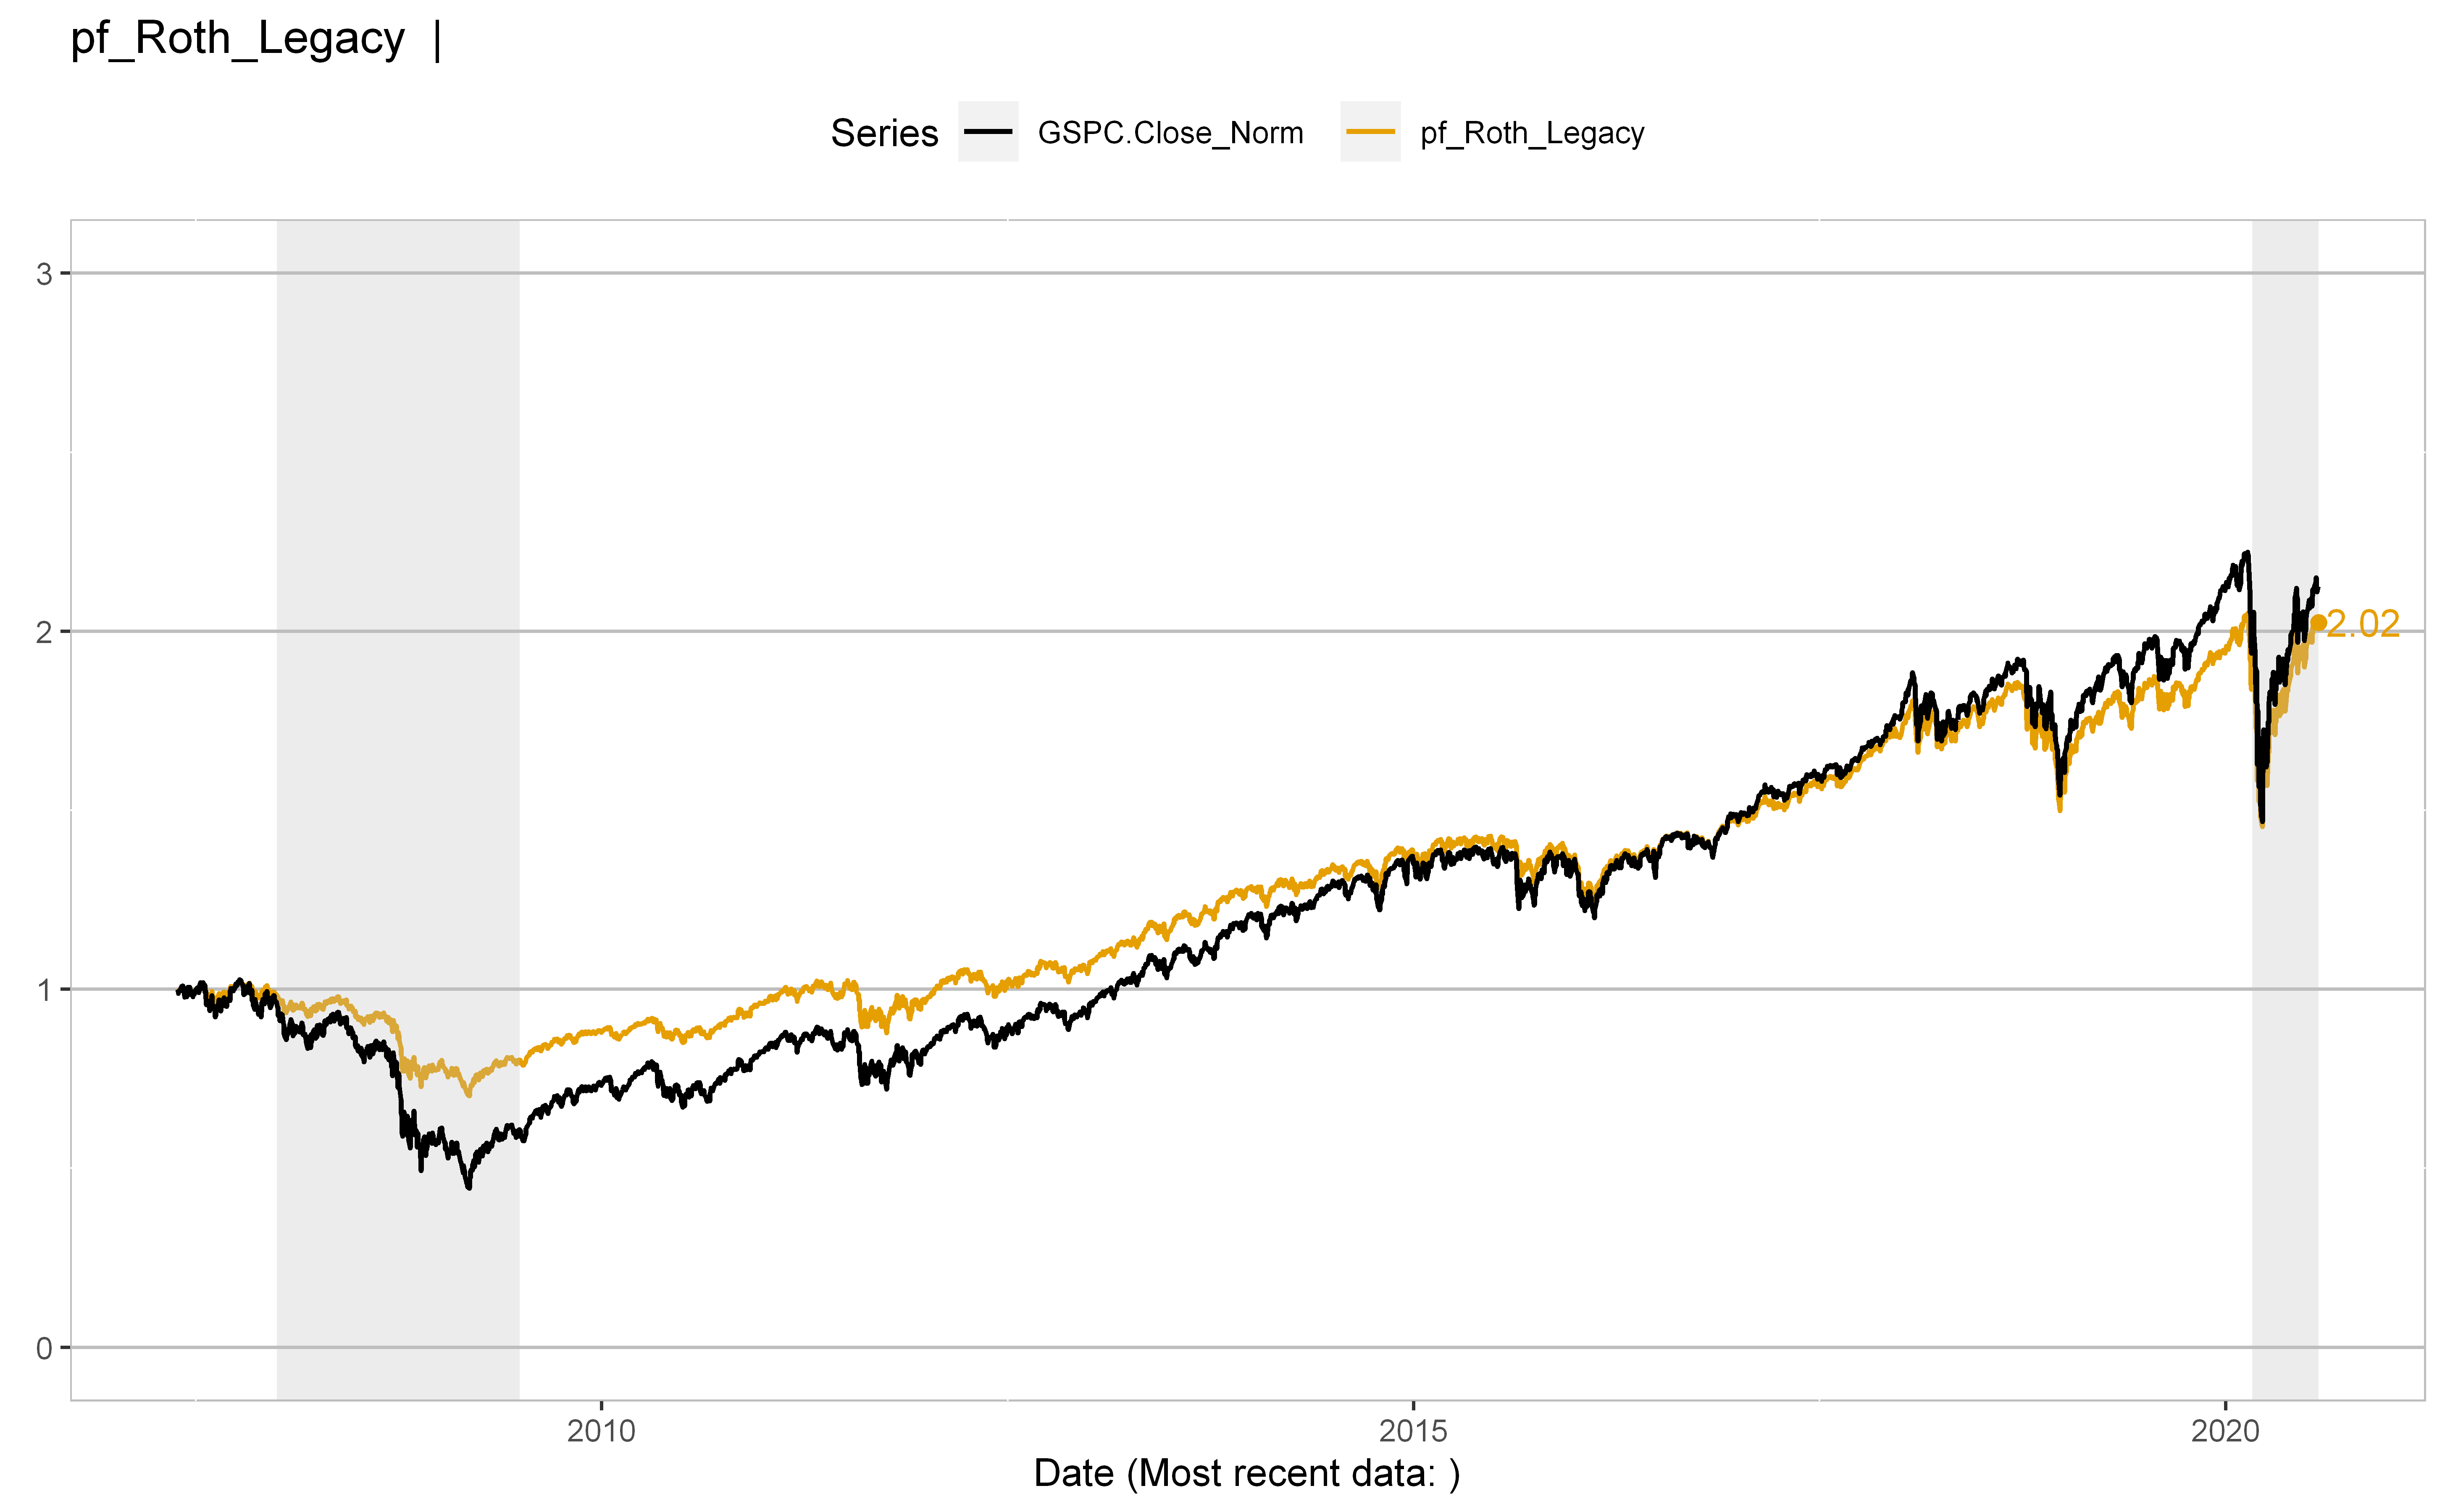

In [23]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay.legacy <- "pf_Roth_Legacy"
ylim <- c(0, 3)
plotSingleBench(dfRecession, datay.legacy, ylim, df.symbols, df.data, string.analysis.start)

## Risk return analysis

This section plots the funds on return and volatility axis. An ideal fund would be in the upper left corner of the plot.

In [24]:
dfRR <- df.symbols[df.symbols[datay.legacy] > 0, ]
dfRR

,string.symbol,string.source,string.description,string.label.y,float.expense.ratio,date.series.start,date.series.end,Max030,Max180,ExpReturn,Volatility,pf_Roth_Legacy,pf_Roth_New
,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<date>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
22,BSV,yahoo,Vanguard Short-Term Bond Index Fund ETF Shares,Dollars,0.05,2007-04-10,2020-07-27,NA,NA,0.6477782,1.757434,2.430843e-01,0.00000000
24,VTWO,yahoo,Vanguard Russell 2000 Index Fund ETF Shares,Dollars,0.10,2010-09-22,2020-07-27,NA,NA,7.1776695,12.719164,4.604016e-02,0.09090909
28,PRWCX,yahoo,T. Rowe Price Capital Appreciation Fund,Dollars,0.70,1986-06-30,2020-07-27,NA,NA,3.7104473,12.797968,9.723370e-02,0.00000000
83,RLG,yahoo,Russell 1000 Growth ETF,Dollars,-1.00,2002-09-30,2020-07-27,NA,NA,10.6371830,16.422116,9.723370e-02,0.00000000
84,DJI,yahoo,Dow Jones Industrial Average,Dollars,-1.00,1985-01-29,2020-07-27,NA,NA,7.3701546,15.306279,9.723370e-02,0.00000000
156,SPY,yahoo,SPDR S&P 500 ETF,Dollars,-1.00,1993-01-29,2020-07-27,NA,NA,7.5764720,16.095964,4.861685e-02,0.00000000
161,VFINX,yahoo,Vanguard 500 Index Investor,Dollars,0.14,1980-01-02,2020-07-27,NA,NA,7.6153878,16.124276,2.455637e-01,0.09090909
164,TMFGX,yahoo,Motley Fool Great America Investor,Dollars,1.16,2010-11-02,2020-07-27,NA,NA,7.7293633,11.641728,1.248481e-01,0.00000000
165,IWM,yahoo,iShares Russell 2000,Dollars,0.19,2000-05-26,2020-07-27,NA,NA,6.9894299,19.293027,4.861685e-05,0.09090909


In [56]:
rrData <- plotReturnVolatility(datay.legacy, df.data, df.symbols)

[1] "Volatility:  -5  |  25"
[1] "Returns:  -5  |  15"


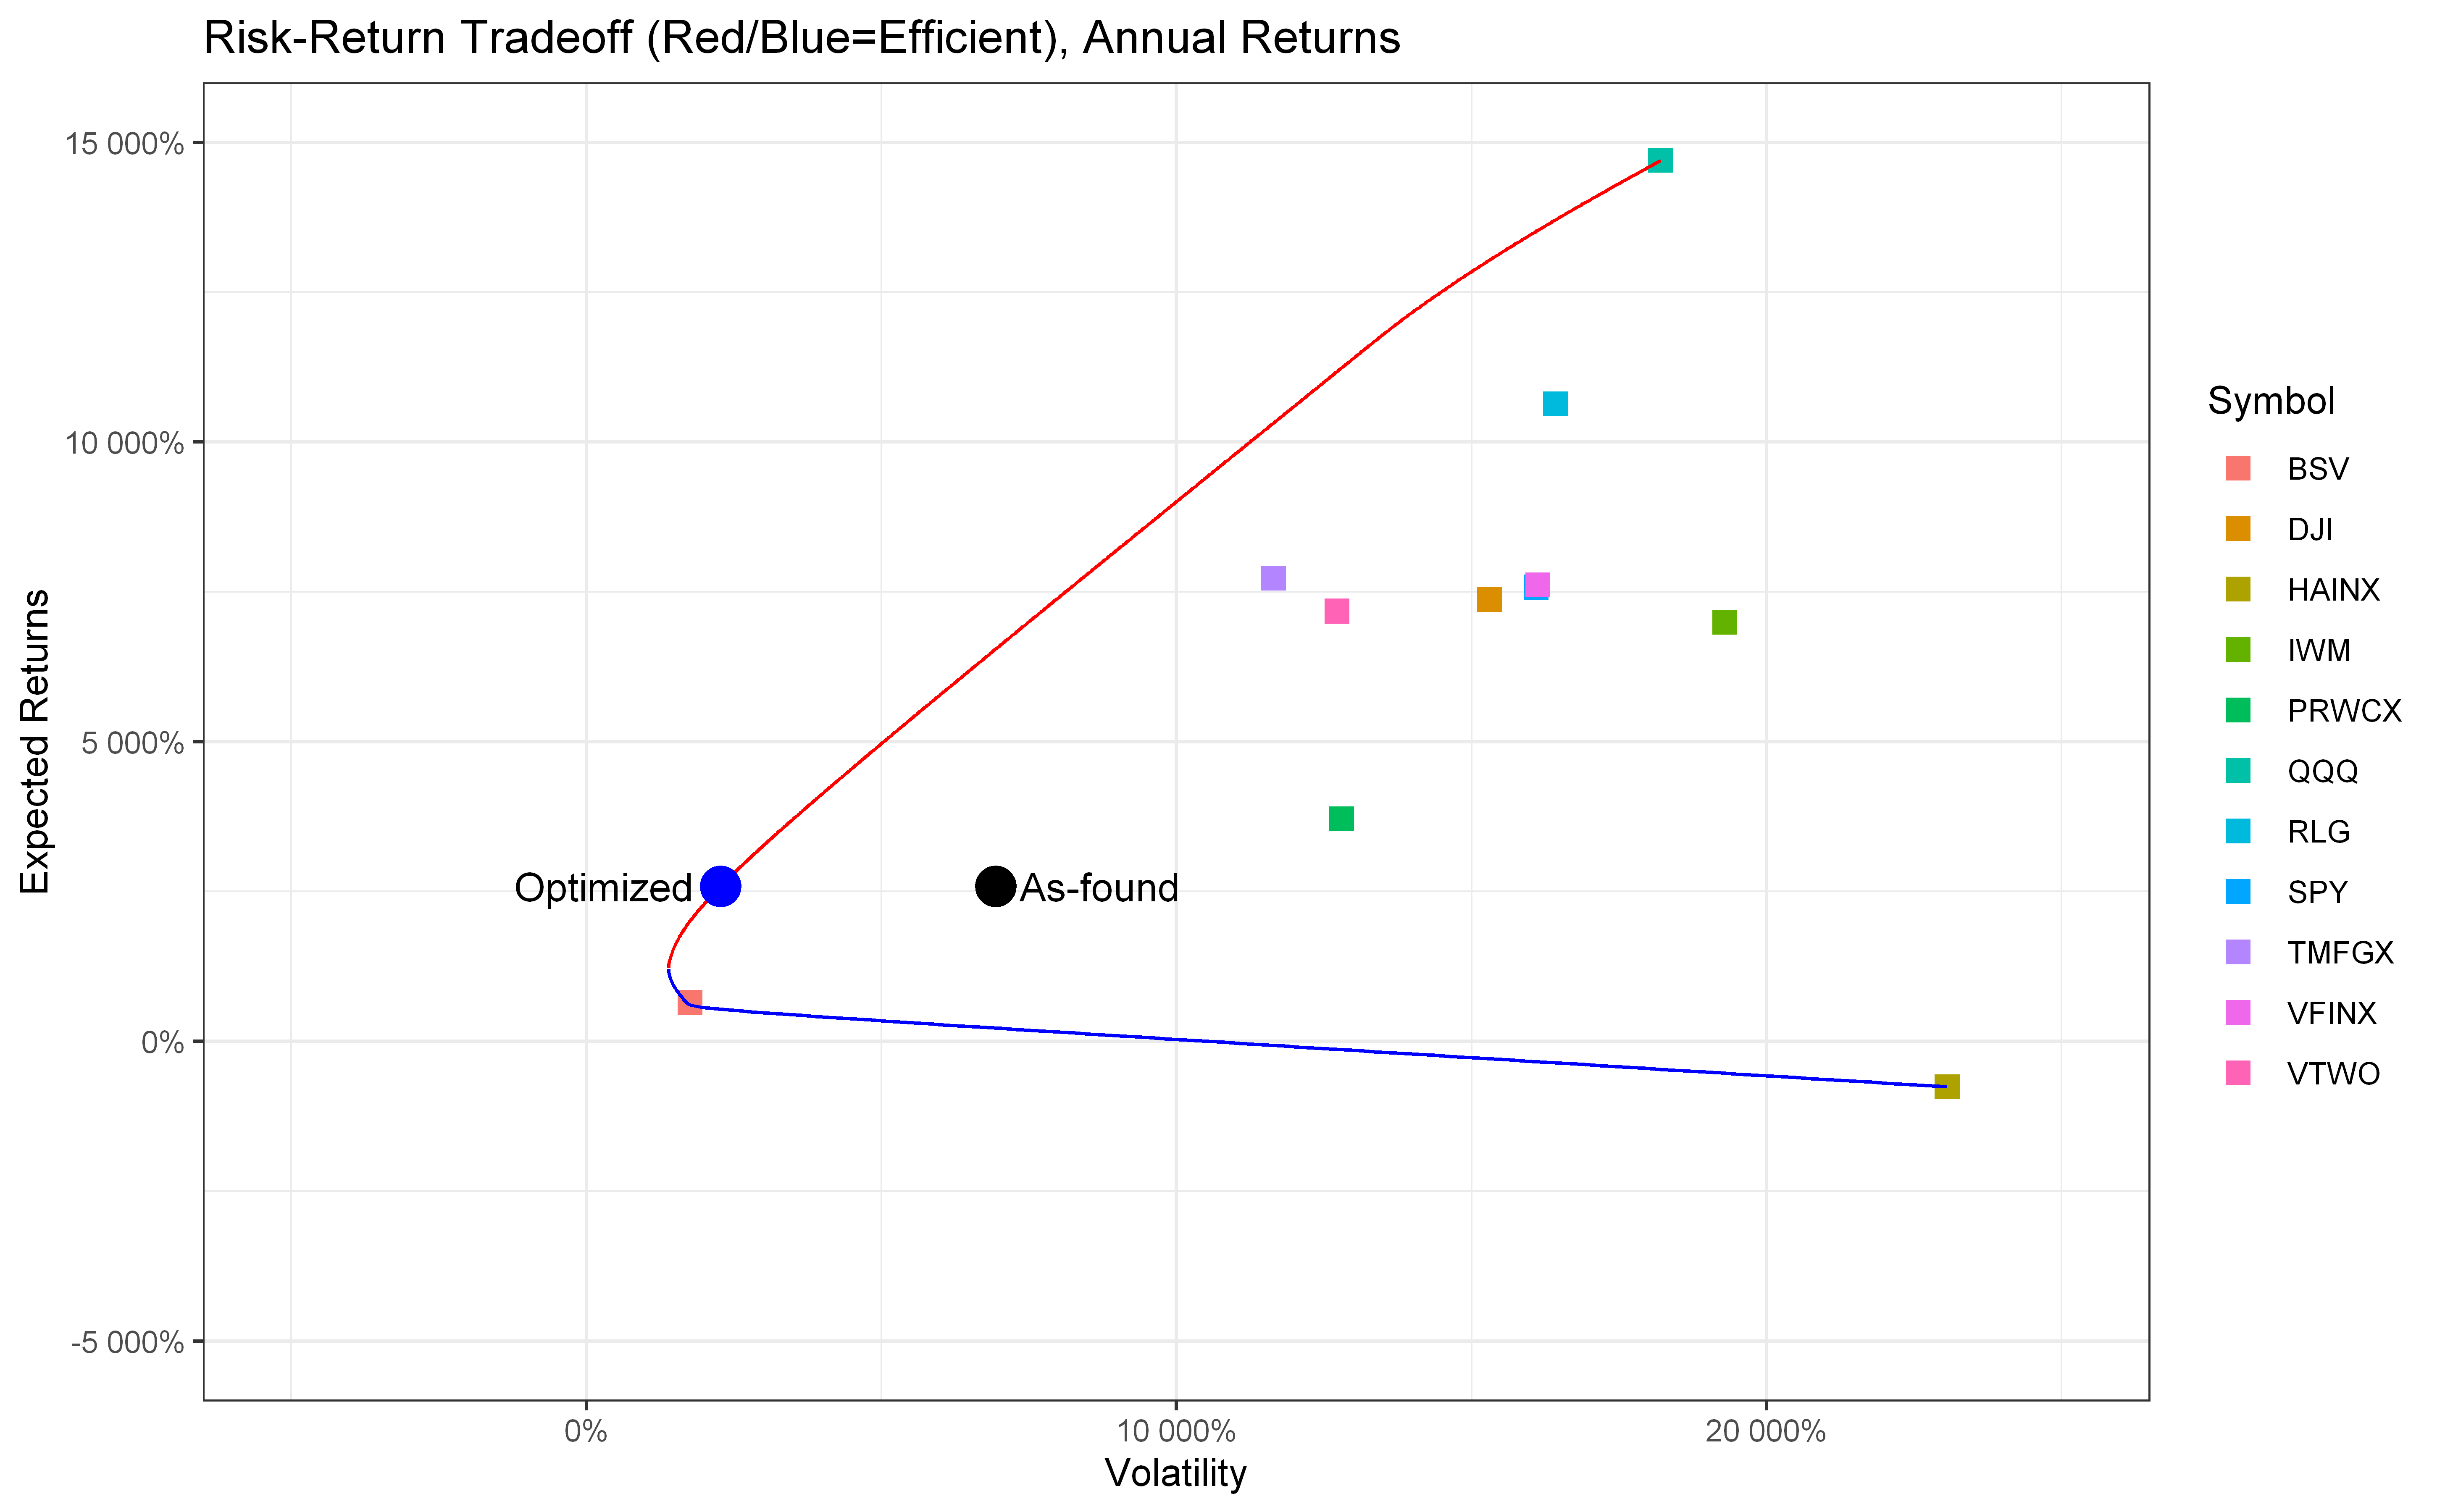

In [57]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
rrData[[2]]

This table shows the portfolio. Column `r datay.legacy` shows the inputted portfolio and `r paste(datay.legacy,"_Opt", sep="")` shows the portfolio with the same returns, but less risk.

In [52]:
tblPort(rrData, datay.legacy)  %>%
  as.character() %>%
  display_html()

,string.symbol,string.description,date.series.start,float.expense.ratio,pf_Roth_Legacy,pf_Roth_Legacy_Opt
22,BSV,Vanguard Short-Term Bond Index Fund ETF Shares,2007-04-10,0.05,0.243,0.795
24,VTWO,Vanguard Russell 2000 Index Fund ETF Shares,2010-09-22,0.10,0.046,0.023
28,PRWCX,T. Rowe Price Capital Appreciation Fund,1986-06-30,0.70,0.097,0.000
83,RLG,Russell 1000 Growth ETF,2002-09-30,-1.00,0.097,0.000
84,DJI,Dow Jones Industrial Average,1985-01-29,-1.00,0.097,0.000
156,SPY,SPDR S&P 500 ETF,1993-01-29,-1.00,0.049,0.000
161,VFINX,Vanguard 500 Index Investor,1980-01-02,0.14,0.246,0.000
164,TMFGX,Motley Fool Great America Investor,2010-11-02,1.16,0.125,0.110
165,IWM,iShares Russell 2000,2000-05-26,0.19,0.000,0.000
167,HAINX,Harbor International Institutional,1987-12-29,0.81,0.000,0.000


In [ ]:
tail(df.data)